
Training and evaluating models for location: Point 1
Location: Point 1, Model: Logistic Regression, Accuracy: 0.8383333333333334, Precision: 0.8798076923076923, Recall: 0.8218562874251497, F1 Score: 0.8498452012383901
Location: Point 1, Model: SVM, Accuracy: 0.9316666666666666, Precision: 0.9521604938271605, Recall: 0.9236526946107785, F1 Score: 0.9376899696048633
Location: Point 1, Model: KNN, Accuracy: 0.9066666666666666, Precision: 0.954248366013072, Recall: 0.874251497005988, F1 Score: 0.9125

Training and evaluating models for location: Point 2
Location: Point 2, Model: Logistic Regression, Accuracy: 0.8291666666666667, Precision: 0.8438538205980066, Recall: 0.8206785137318255, F1 Score: 0.8321048321048321
Location: Point 2, Model: SVM, Accuracy: 0.9425, Precision: 0.9493464052287581, Recall: 0.938610662358643, F1 Score: 0.9439480097481722
Location: Point 2, Model: KNN, Accuracy: 0.9116666666666666, Precision: 0.9282136894824707, Recall: 0.8982229402261712, F1 Score: 0.9129720853

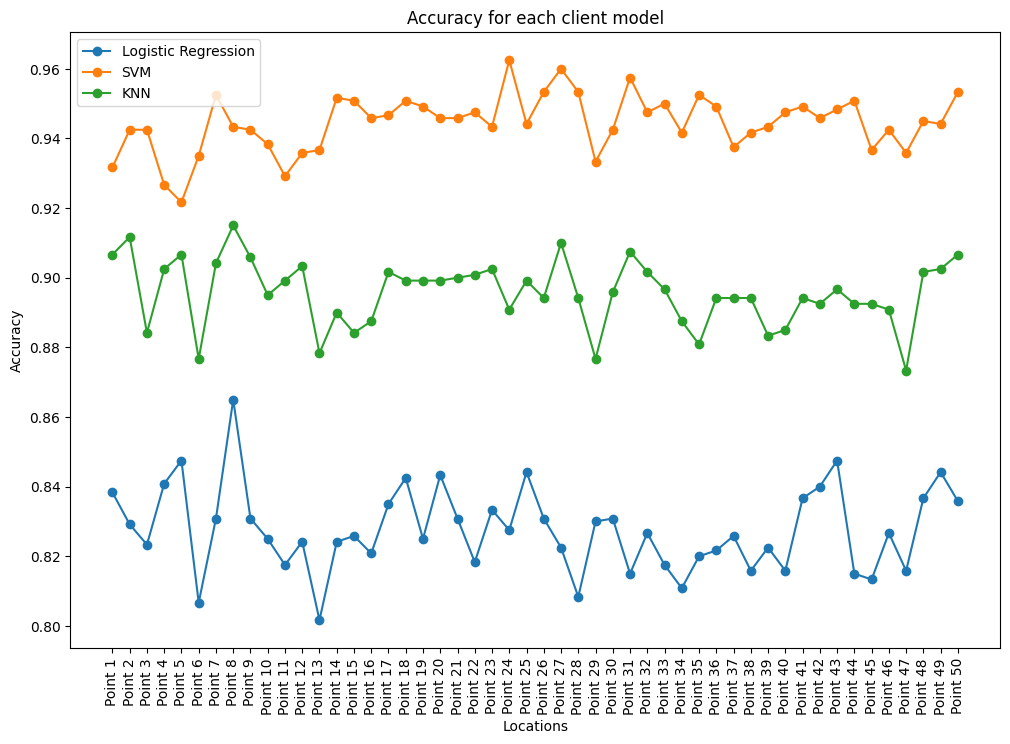

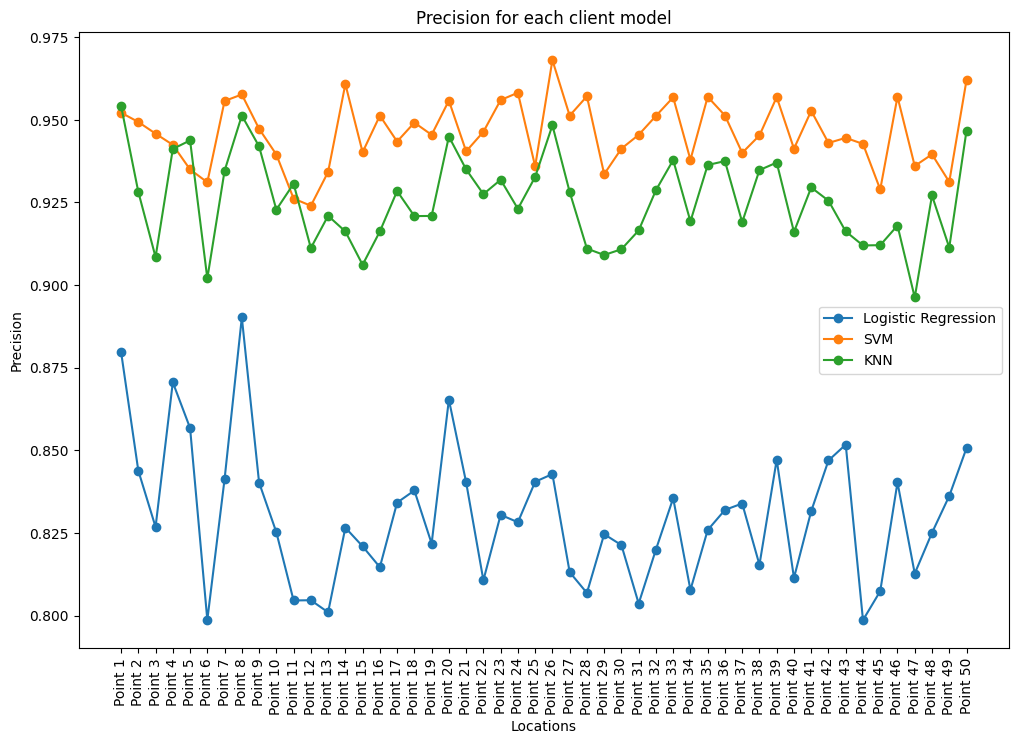

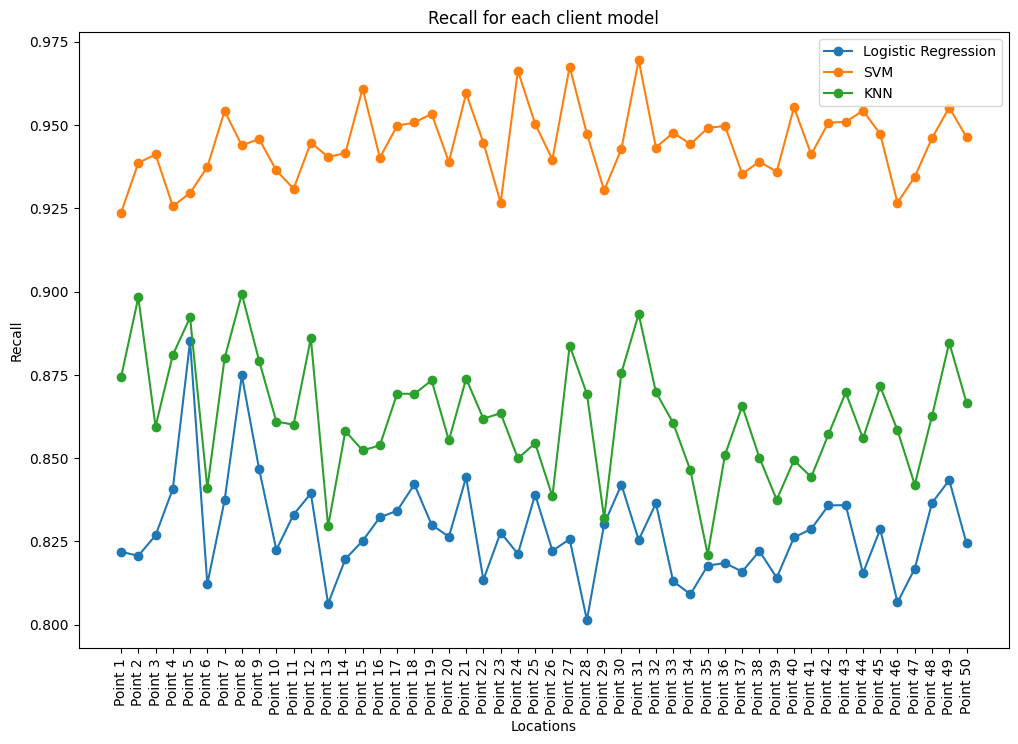

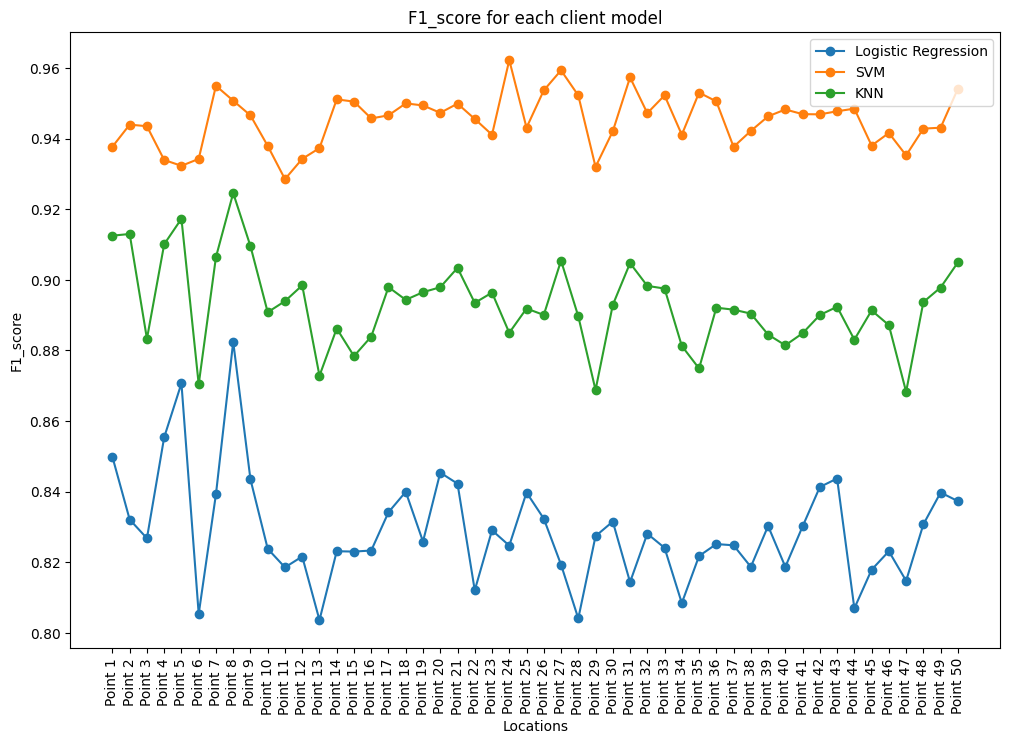

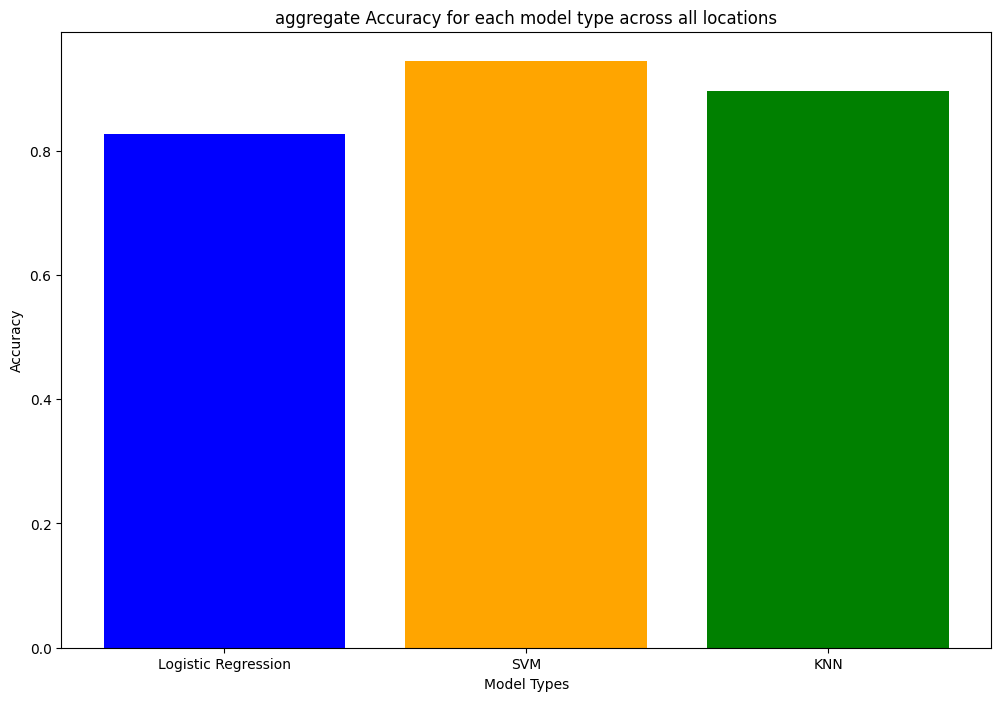

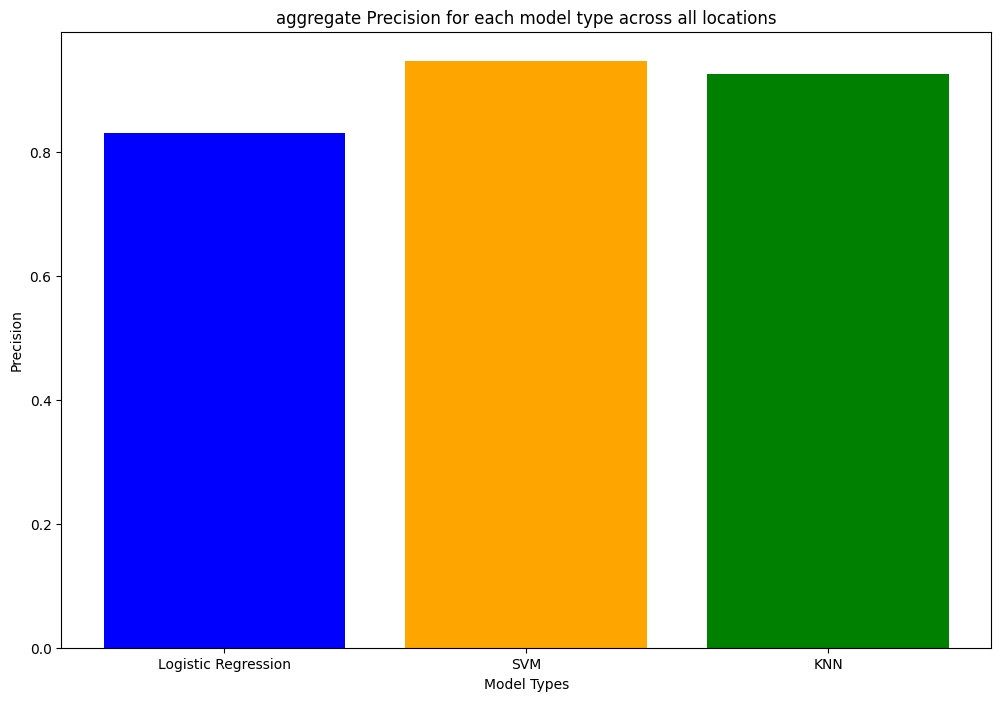

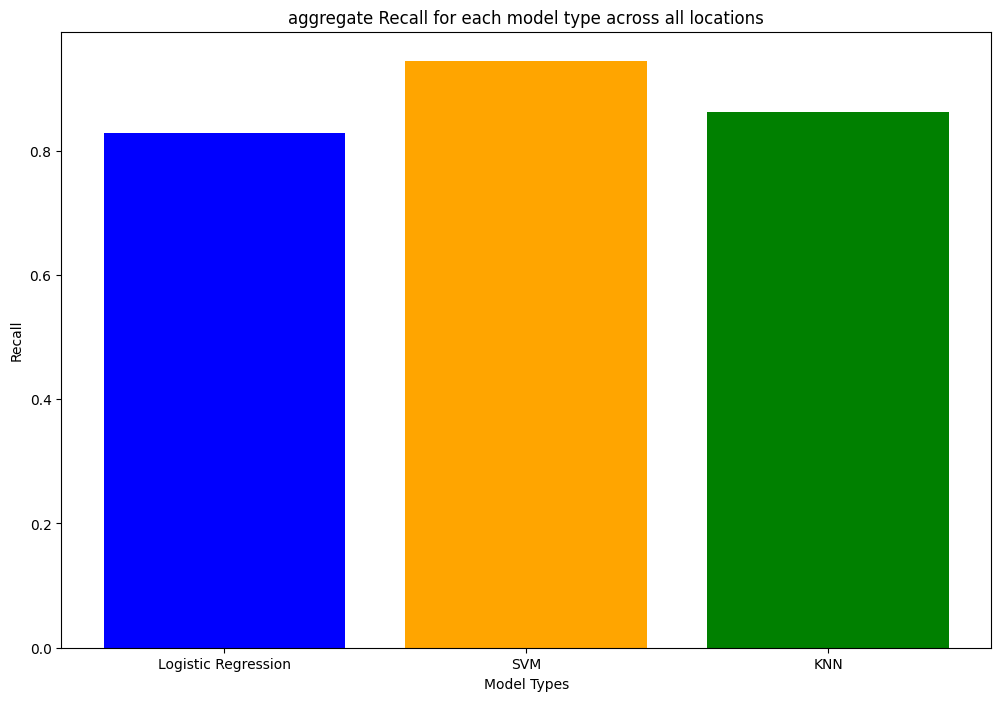

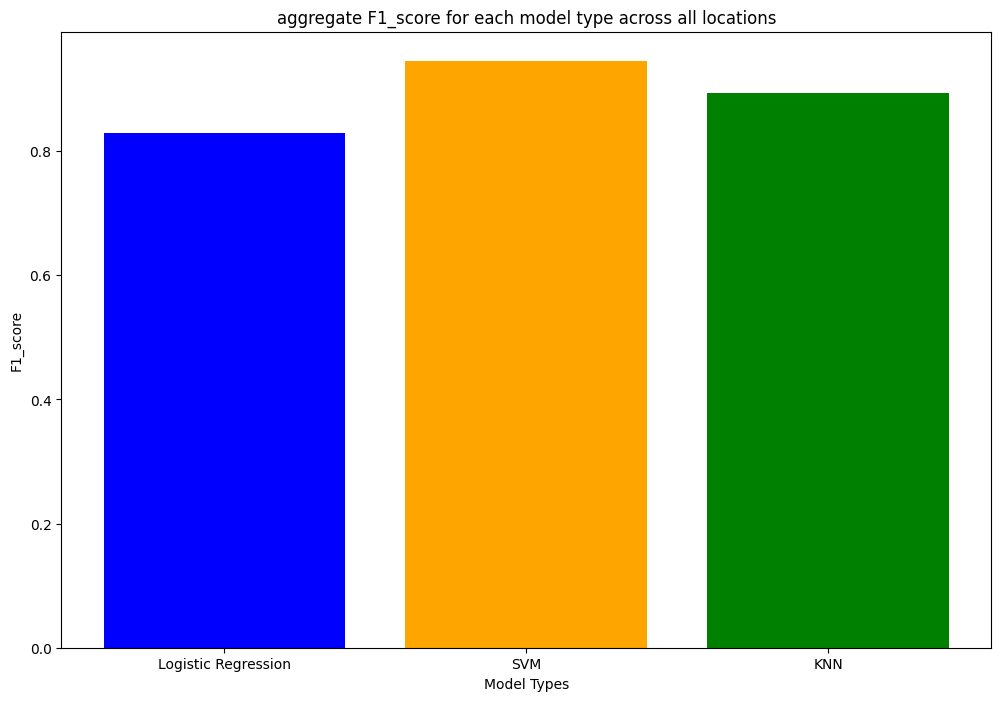

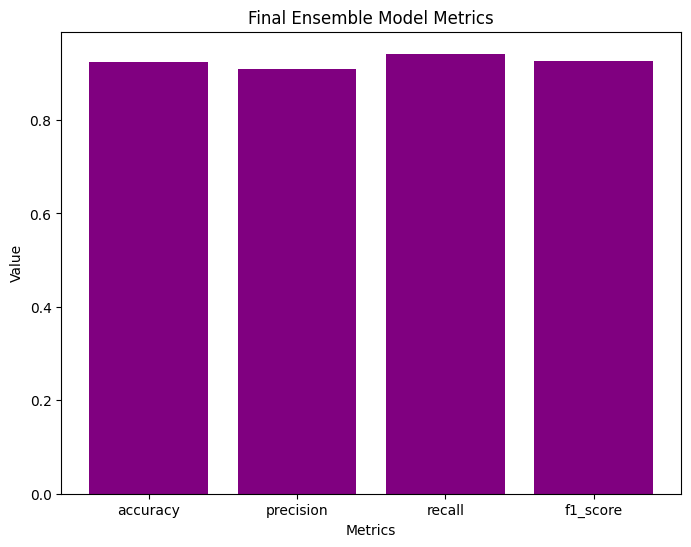

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

# Load the dataset
data = pd.read_csv('sensor_data_1000.csv')

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 0', 'timestamp'])

# Encode the 'location' column
label_encoder = LabelEncoder()
data['location_encoded'] = label_encoder.fit_transform(data['location'])

# Normalize the features
scaler = StandardScaler()
features = data.drop(columns=['anomalized', 'location'])
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
scaled_data['anomalized'] = data['anomalized']
scaled_data['location'] = data['location']
scaled_data['location_encoded'] = data['location_encoded']

# Split the dataset by location
locations = data['location'].unique()
location_data = {loc: scaled_data[scaled_data['location'] == loc].drop(columns=['location_encoded', 'location']) for loc in locations}

# Create training and test sets for each location
train_data = {}
test_data = {}
for loc in locations:
    loc_data = location_data[loc]
    train, test = train_test_split(loc_data, test_size=0.2, random_state=42)
    train_data[loc] = train
    test_data[loc] = test

# Define the list of models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Training function for each model
def train_models(data, models):
    trained_models = {}
    for name, model in models.items():
        model_clone = clone(model)
        X_train = data.drop(columns=['anomalized']).values
        y_train = data['anomalized'].values
        model_clone.fit(X_train, y_train)
        trained_models[name] = model_clone
    return trained_models

# Evaluate models and print metrics
def evaluate_models(test_data, test_labels, models, location):
    metrics = {}
    for name, model in models.items():
        y_pred = model.predict(test_data)
        accuracy = accuracy_score(test_labels, y_pred)
        precision = precision_score(test_labels, y_pred)
        recall = recall_score(test_labels, y_pred)
        f1 = f1_score(test_labels, y_pred)
        metrics[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        print(f'Location: {location}, Model: {name}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')
    return metrics

# Aggregate predictions function
def aggregate_predictions(test_data, models):
    predictions = np.array([model.predict_proba(test_data)[:, 1] for model in models.values()])
    avg_prediction = np.mean(predictions, axis=0)
    final_prediction = (avg_prediction > 0.5).astype(int)
    return final_prediction

# Train models on each client's data, evaluate them, and aggregate results
global_models = {}
all_test_data = np.vstack([test_data[loc].drop(columns=['anomalized']).values for loc in locations])
all_test_labels = np.hstack([test_data[loc]['anomalized'].values for loc in locations])
all_metrics = {}

for loc in locations:
    print(f'\nTraining and evaluating models for location: {loc}')
    global_models[loc] = train_models(train_data[loc], models)
    all_metrics[loc] = evaluate_models(test_data[loc].drop(columns=['anomalized']).values, test_data[loc]['anomalized'].values, global_models[loc], loc)

# Aggregate metrics for each model type across all locations
model_type_metrics = {model: {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []} for model in models}
for loc_metrics in all_metrics.values():
    for model_name, metrics in loc_metrics.items():
        for metric_name, metric_value in metrics.items():
            model_type_metrics[model_name][metric_name].append(metric_value)

# Calculate aggregate metrics for each model type
aggregate_model_type_metrics = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in model_type_metrics.items()}

print("\naggregate metrics for each model type across all locations:")
for model, metrics in aggregate_model_type_metrics.items():
    print(f"Model: {model}, Metrics: {metrics}")

# Aggregate predictions from all models of each type across all locations
final_predictions = []
for model_name in models:
    model_predictions = np.array([global_models[loc][model_name].predict_proba(all_test_data)[:, 1] for loc in locations])
    avg_prediction = np.mean(model_predictions, axis=0)
    final_prediction = (avg_prediction > 0.5).astype(int)
    final_predictions.append(final_prediction)

# Final aggregate of all model types
final_ensemble_prediction = np.mean(final_predictions, axis=0)
final_ensemble_prediction = (final_ensemble_prediction > 0.5).astype(int)
final_accuracy = accuracy_score(all_test_labels, final_ensemble_prediction)
final_precision = precision_score(all_test_labels, final_ensemble_prediction)
final_recall = recall_score(all_test_labels, final_ensemble_prediction)
final_f1 = f1_score(all_test_labels, final_ensemble_prediction)

print(f'\nFinal Aggregated Model Metrics - Accuracy: {final_accuracy}, Precision: {final_precision}, Recall: {final_recall}, F1 Score: {final_f1}')

# Visualize the metrics for each client model using line graphs
def plot_metrics_line(all_metrics, metric_name):
    plt.figure(figsize=(12, 8))
    for model in models:
        model_metrics = [all_metrics[loc][model][metric_name] for loc in locations]
        plt.plot(locations, model_metrics, marker='o', label=model)
    
    plt.xlabel('Locations')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} for each client model')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

# Visualize the aggregate metrics for each model type
def plot_aggregate_model_metrics(aggregate_model_type_metrics, metric_name):
    plt.figure(figsize=(12, 8))
    model_names = list(aggregate_model_type_metrics.keys())
    metrics = [aggregate_model_type_metrics[model][metric_name] for model in model_names]
    plt.bar(model_names, metrics, color=['blue', 'orange', 'green', 'red'])
    
    plt.xlabel('Model Types')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'aggregate {metric_name.capitalize()} for each model type across all locations')
    plt.show()

# Plot accuracy, precision, recall, and F1 score using line graphs
plot_metrics_line(all_metrics, 'accuracy')
plot_metrics_line(all_metrics, 'precision')
plot_metrics_line(all_metrics, 'recall')
plot_metrics_line(all_metrics, 'f1_score')

# Plot aggregate metrics for each model type
plot_aggregate_model_metrics(aggregate_model_type_metrics, 'accuracy')
plot_aggregate_model_metrics(aggregate_model_type_metrics, 'precision')
plot_aggregate_model_metrics(aggregate_model_type_metrics, 'recall')
plot_aggregate_model_metrics(aggregate_model_type_metrics, 'f1_score')

# Visualize the final ensemble metrics
def plot_final_ensemble_metrics(final_metrics):
    plt.figure(figsize=(8, 6))
    metric_names = list(final_metrics.keys())
    metrics = list(final_metrics.values())
    plt.bar(metric_names, metrics, color='purple')
    
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Final Ensemble Model Metrics')
    plt.show()

# Plot final ensemble metrics
final_metrics = {
    'accuracy': final_accuracy,
    'precision': final_precision,
    'recall': final_recall,
    'f1_score': final_f1
}
plot_final_ensemble_metrics(final_metrics)
